In [ ]:
!nvidia-smi


Mon Jul 28 07:39:20 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla T4                       Off |   00000000:00:04.0 Off |                    0 |
| N/A   52C    P8             11W /   70W |       0MiB /  15360MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [ ]:
import warnings
import cv2
import matplotlib.pyplot as plt
import os
import tensorflow as tf
from tensorflow import keras
from PIL import Image
import numpy as np
import seaborn as sns
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import normalize
from tensorflow.keras.applications import ResNet50V2
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Activation, Dropout, Flatten, Dense, Conv2D, MaxPooling2D
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import Binarizer
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from tensorflow.keras import layers
from tensorflow.keras.optimizers import SGD
import time

In [ ]:
from google.colab import drive
drive.mount('/content/driv')

Drive already mounted at /content/driv; to attempt to forcibly remount, call drive.mount("/content/driv", force_remount=True).


In [ ]:
timeinicial= time.time()
path ='/content/driv/MyDrive/deteccao_tumores/dataset_cerebros/nao'
path2 ='/content/driv/MyDrive/deteccao_tumores/dataset_cerebros/sim'
arquivos=[os.path.join(path,f) for f in sorted(os.listdir(path))]
arquivos2=[os.path.join(path2,i) for i in sorted(os.listdir(path2))]


largura, altura=299,299
dataset= [] #informações sobre os pixels
label = [] #tipo de classe

for caminho in arquivos:

  imagem= cv2.imread(caminho)
  imagem = cv2.resize(imagem,(largura, altura)) #redimencionando todas as imagens
  #imagem = cv2.cvtColor(imagem, cv2.COLOR_BGR2GRAY) #transformando as imagens para escala de cinza
  #cv2_imshow(imagem)

  dataset.append(np.array(imagem))
  label.append(0)# adiciona a classe não tem tumor


for caminho2 in arquivos2:

  imagem= cv2.imread(caminho2)
  imagem = cv2.resize(imagem,(largura, altura))#redimencionando todas as imagens
  #imagem = cv2.cvtColor(imagem, cv2.COLOR_BGR2GRAY) #transformando as imagens para escala de cinza
  #cv2_imshow(imagem)

  dataset.append(np.array(imagem))
  label.append(1)# adiciona classe com tumor


dataset=np.array(dataset)# informação dos pixels
label=np.array(label) # informação das classe
timefinal= time.time()
print(f"duração: {timefinal-timeinicial} segundos")

duração: 16.22335386276245 segundos


In [ ]:
from sklearn.model_selection import train_test_split
# Base de treinamento e teste
x_train, x_test, y_train, y_test=train_test_split(dataset, label, test_size=0.2, random_state=0, shuffle= True)
x_train=normalize(x_train,axis=1)
x_test=normalize(x_test,axis=1)

In [ ]:
# Modelo ResNet50V2

base_model =  tf.keras.applications.ResNet50V2(include_top= False, weights='imagenet', input_shape=(299, 299, 3), name="resnet50v2")
base_model.trainable = False  # Transfer learning: congela base

# adiciona camada para output
x = tf.keras.layers.GlobalAveragePooling2D()(base_model.output)
x = tf.keras.layers.Dense(256, activation='relu')(x)
x = tf.keras.layers.Dropout(0.3)(x)
output = Dense(1, activation='sigmoid')(x)
model = tf.keras.Model(inputs=base_model.input, outputs=output)

model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 299, 299,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_pad           │ (None, 305, 305,  │          0 │ input_layer[0][0] │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_conv (Conv2D) │ (None, 150, 150,  │      9,472 │ conv1_pad[0][0]   │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pad           │ (None, 152, 152,  │          0 │ conv1_conv[0][0]  │
│ (ZeroPadding2D)     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pool          │ (None, 75, 75,    │          0 │ pool1_pad[0][0]   │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_preac… │ (None, 75, 75,    │        256 │ pool1_pool[0][0]  │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_preac… │ (None, 75, 75,    │          0 │ conv2_block1_pre… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_conv │ (None, 75, 75,    │      4,096 │ conv2_block1_pre… │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_bn   │ (None, 75, 75,    │        256 │ conv2_block1_1_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_relu │ (None, 75, 75,    │          0 │ conv2_block1_1_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_pad  │ (None, 77, 77,    │          0 │ conv2_block1_1_r… │
│ (ZeroPadding2D)     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_conv │ (None, 75, 75,    │     36,864 │ conv2_block1_2_p… │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_bn   │ (None, 75, 75,    │        256 │ conv2_block1_2_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_relu │ (None, 75, 75,    │          0 │ conv2_block1_2_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_conv │ (None, 75, 75,    │     16,640 │ conv2_block1_pre… │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_conv │ (None, 75, 75,    │     16,640 │ conv2_block1_2_r… │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_out    │ (None, 75, 75,    │          0 │ conv2_block1_0_c

 Total params: 24,089,601 (91.89 MB)

 Trainable params: 524,801 (2.00 MB)

 Non-trainable params: 23,564,800 (89.89 MB)

In [ ]:
tempo_inicial=time.time()
# adam = keras.optimizers.Adam(learning_rate=0.01)
# taxa de aprendizado padrão da SGD: 0.01
# otimizador SGD produz maior acurária caso comparado ao Adam
# treinar apenas camadas adicionadas
model.compile(loss=tf.keras.losses.BinaryCrossentropy(),optimizer=keras.optimizers.SGD(learning_rate=0.01),metrics=['accuracy'])
history=model.fit(x_train,y_train,batch_size=16,epochs=50, validation_data=(x_test,y_test)) #batchsize siginifica que vamos enviar 16 em 16 imagens para a rede neural, sem misturar as imagens enviando com a ordem que está n
tempo_final=time.time()

tempo_final-tempo_inicial

Epoch 1/50
109/109 ━━━━━━━━━━━━━━━━━━━━ 36s 204ms/step - accuracy: 0.7858 - loss: 0.4828 - val_accuracy: 0.9103 - val_loss: 0.2609
Epoch 2/50
109/109 ━━━━━━━━━━━━━━━━━━━━ 9s 81ms/step - accuracy: 0.9013 - loss: 0.2616 - val_accuracy: 0.9241 - val_loss: 0.2103
Epoch 3/50
109/109 ━━━━━━━━━━━━━━━━━━━━ 9s 82ms/step - accuracy: 0.9206 - loss: 0.2096 - val_accuracy: 0.9425 - val_loss: 0.1702
Epoch 4/50
109/109 ━━━━━━━━━━━━━━━━━━━━ 9s 82ms/step - accuracy: 0.9447 - loss: 0.1707 - val_accuracy: 0.9494 - val_loss: 0.1568
Epoch 5/50
109/109 ━━━━━━━━━━━━━━━━━━━━ 9s 83ms/step - accuracy: 0.9503 - loss: 0.1579 - val_accuracy: 0.9517 - val_loss: 0.1444
Epoch 6/50
109/109 ━━━━━━━━━━━━━━━━━━━━ 9s 84ms/step - accuracy: 0.9400 - loss: 0.1489 - val_accuracy: 0.9517 - val_loss: 0.1327
Epoch 7/50
109/109 ━━━━━━━━━━━━━━━━━━━━ 9s 84ms/step - accuracy: 0.9609 - loss: 0.1273 - val_accuracy: 0.9586 - val_loss: 0.1250
Epoch 8/50
109/109 ━━━━━━━━━━━━━━━━━━━━ 9s 84ms/step - accuracy: 0.9588 - loss: 0.1263 - val_ac

485.8089234828949

In [ ]:
# realizando fine tuning
tempo_inicial=time.time()
base_model.trainable = True # descongela modelo
model.summary()

# inicia fine tune a partir da camada 100
fine_tune_at = 200

# congela todas as camadas até chegar na camada de `fine_tune_at`
for layer in base_model.layers[:fine_tune_at]:
  layer.trainable = False

model.compile(loss=tf.keras.losses.BinaryCrossentropy(),optimizer=keras.optimizers.SGD(learning_rate=0.00001),metrics=['accuracy'])
history=model.fit(x_train,y_train,batch_size=16,epochs=120, initial_epoch=len(history.epoch), validation_data=(x_test,y_test)) #batchsize siginifica que vamos enviar 16 em 16 imagens para a rede neural, sem misturar as imagens enviando com a ordem que está n
tempo_final=time.time()

tempo_final-tempo_inicial

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 299, 299,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_pad           │ (None, 305, 305,  │          0 │ input_layer[0][0] │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_conv (Conv2D) │ (None, 150, 150,  │      9,472 │ conv1_pad[0][0]   │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pad           │ (None, 152, 152,  │          0 │ conv1_conv[0][0]  │
│ (ZeroPadding2D)     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pool          │ (None, 75, 75,    │          0 │ pool1_pad[0][0]   │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_preac… │ (None, 75, 75,    │        256 │ pool1_pool[0][0]  │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_preac… │ (None, 75, 75,    │          0 │ conv2_block1_pre… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_conv │ (None, 75, 75,    │      4,096 │ conv2_block1_pre… │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_bn   │ (None, 75, 75,    │        256 │ conv2_block1_1_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_relu │ (None, 75, 75,    │          0 │ conv2_block1_1_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_pad  │ (None, 77, 77,    │          0 │ conv2_block1_1_r… │
│ (ZeroPadding2D)     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_conv │ (None, 75, 75,    │     36,864 │ conv2_block1_2_p… │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_bn   │ (None, 75, 75,    │        256 │ conv2_block1_2_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_relu │ (None, 75, 75,    │          0 │ conv2_block1_2_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_conv │ (None, 75, 75,    │     16,640 │ conv2_block1_pre… │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_conv │ (None, 75, 75,    │     16,640 │ conv2_block1_2_r… │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_out    │ (None, 75, 75,    │          0 │ conv2_block1_0_c

 Total params: 24,089,603 (91.89 MB)

 Trainable params: 24,044,161 (91.72 MB)

 Non-trainable params: 45,440 (177.50 KB)

 Optimizer params: 2 (12.00 B)

Epoch 51/120
109/109 ━━━━━━━━━━━━━━━━━━━━ 26s 158ms/step - accuracy: 0.9995 - loss: 0.0130 - val_accuracy: 0.9724 - val_loss: 0.0705
Epoch 52/120
109/109 ━━━━━━━━━━━━━━━━━━━━ 9s 84ms/step - accuracy: 0.9979 - loss: 0.0160 - val_accuracy: 0.9724 - val_loss: 0.0705
Epoch 53/120
109/109 ━━━━━━━━━━━━━━━━━━━━ 9s 85ms/step - accuracy: 0.9983 - loss: 0.0165 - val_accuracy: 0.9724 - val_loss: 0.0705
Epoch 54/120
109/109 ━━━━━━━━━━━━━━━━━━━━ 9s 84ms/step - accuracy: 0.9964 - loss: 0.0186 - val_accuracy: 0.9724 - val_loss: 0.0705
Epoch 55/120
109/109 ━━━━━━━━━━━━━━━━━━━━ 9s 84ms/step - accuracy: 0.9977 - loss: 0.0163 - val_accuracy: 0.9724 - val_loss: 0.0705
Epoch 56/120
109/109 ━━━━━━━━━━━━━━━━━━━━ 9s 84ms/step - accuracy: 0.9987 - loss: 0.0150 - val_accuracy: 0.9724 - val_loss: 0.0705
Epoch 57/120
109/109 ━━━━━━━━━━━━━━━━━━━━ 9s 83ms/step - accuracy: 1.0000 - loss: 0.0156 - val_accuracy: 0.9724 - val_loss: 0.0705
Epoch 58/120
109/109 ━━━━━━━━━━━━━━━━━━━━ 9s 84ms/step - accuracy: 0.9989 - loss:

660.031495809555

In [ ]:
print(f"o codigo demorou {int(tempo_final-tempo_inicial)} segundos")

o codigo demorou 660 segundos


In [ ]:
from sklearn.preprocessing import Binarizer
# predição para obter acurácia do modelo
score = model.evaluate(x_test, y_test)
prediction = model.predict(x_test)
#############
binarizer = Binarizer(threshold=0.50).fit(prediction)
binary = binarizer.transform(prediction)
#############
y_test = y_test
y_pred = binary

14/14 ━━━━━━━━━━━━━━━━━━━━ 17s 608ms/step - accuracy: 0.9833 - loss: 0.0545
14/14 ━━━━━━━━━━━━━━━━━━━━ 8s 363ms/step


In [ ]:
print("Resultados da Classificação = ")
print(classification_report(y_test,y_pred))

Resultados da Classificação = 
              precision    recall  f1-score   support

           0       0.98      0.99      0.98       309
           1       0.97      0.94      0.96       126

    accuracy                           0.97       435
   macro avg       0.97      0.97      0.97       435
weighted avg       0.97      0.97      0.97       435



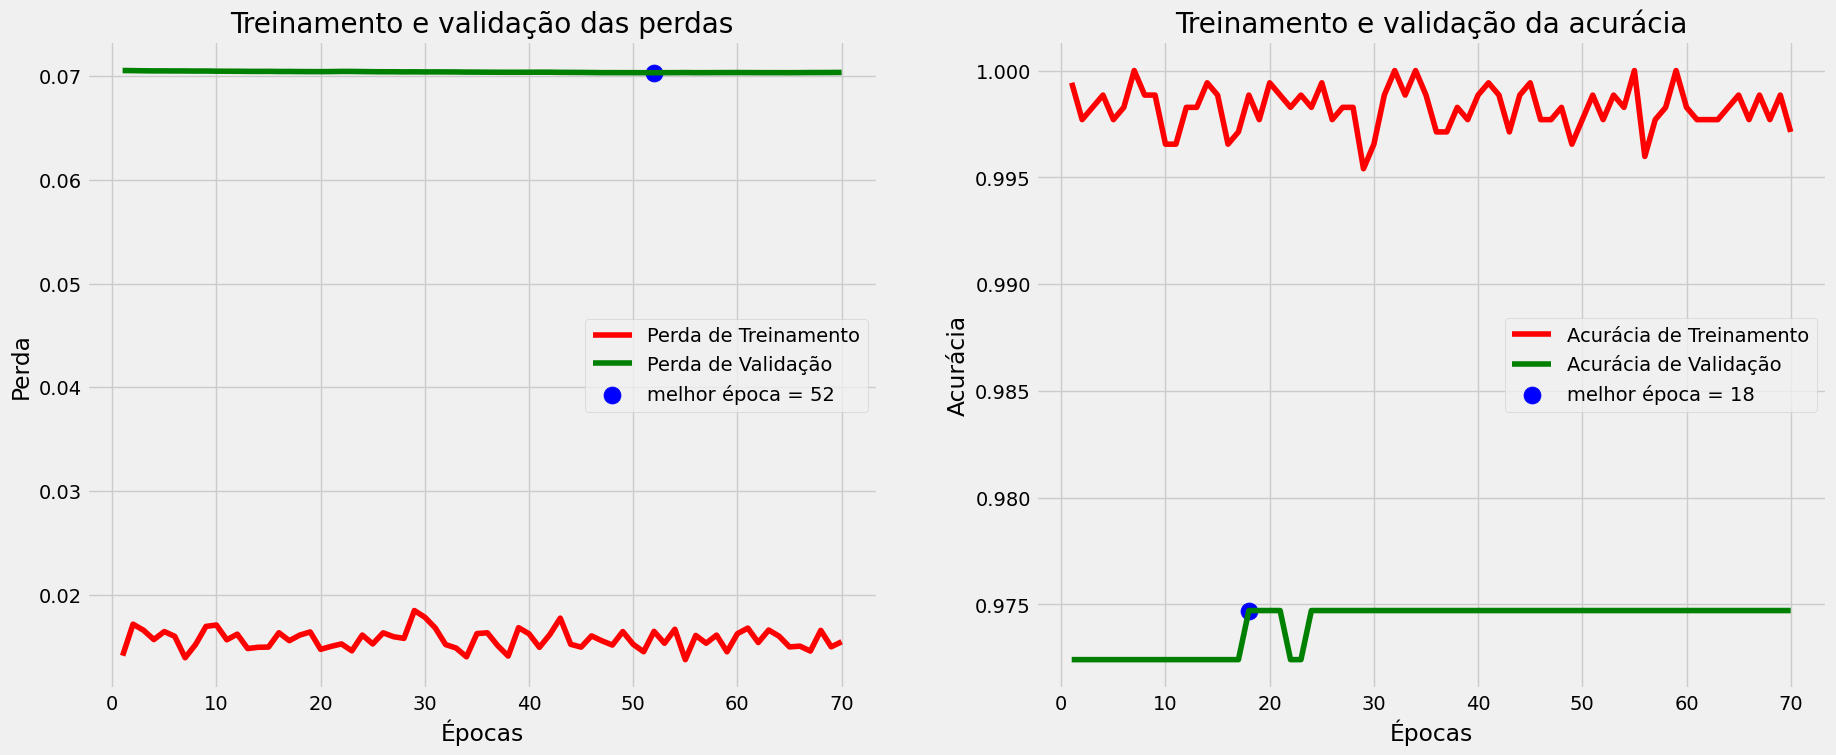

<Figure size 640x480 with 0 Axes>

In [ ]:
def tr_plot(tr_data, start_epoch):
    #Plot the loss and accuracy curve
    tacc=tr_data.history['accuracy']
    tloss=tr_data.history['loss']
    vacc=tr_data.history['val_accuracy']
    vloss=tr_data.history['val_loss']
    Epoch_count=len(tacc)+ start_epoch
    Epochs=[]
    for i in range (start_epoch ,Epoch_count):
        Epochs.append(i+1)
    index_loss=np.argmin(vloss)
    val_lowest=vloss[index_loss]
    index_acc=np.argmax(vacc)
    acc_highest=vacc[index_acc]
    plt.style.use('fivethirtyeight')
    sc_label='melhor época = '+ str(index_loss+1 +start_epoch)
    vc_label='melhor época = '+ str(index_acc + 1+ start_epoch)
    fig,axes=plt.subplots(nrows=1, ncols=2, figsize=(20,8))
    axes[0].plot(Epochs,tloss, 'r', label='Perda de Treinamento')
    axes[0].plot(Epochs,vloss,'g',label='Perda de Validação' )
    axes[0].scatter(index_loss+1 +start_epoch,val_lowest, s=150, c= 'blue', label=sc_label)
    axes[0].set_title('Treinamento e validação das perdas')
    axes[0].set_xlabel('Épocas')
    axes[0].set_ylabel('Perda')
    axes[0].legend()
    axes[1].plot (Epochs,tacc,'r',label= 'Acurácia de Treinamento')
    axes[1].plot (Epochs,vacc,'g',label= 'Acurácia de Validação')
    axes[1].scatter(index_acc+1 +start_epoch,acc_highest, s=150, c= 'blue', label=vc_label)
    axes[1].set_title('Treinamento e validação da acurácia')
    axes[1].set_xlabel('Épocas')
    axes[1].set_ylabel('Acurácia')
    axes[1].legend()
    plt.tight_layout

    plt.show()

tr_plot(history,0)
plt.savefig('history.png')
model.save('/content/driv/MyDrive/deteccao_tumores/modelos/modelo_resnet50v2.h5')

In [ ]:
caminho_modelo = '/content/driv/MyDrive/deteccao_tumores/modelos/modelo_resnet50v2.h5'
modelo = tf.keras.models.load_model(caminho_modelo)
largura, altura=299,299

\Classificando imagem: /content/driv/MyDrive/deteccao_tumores/dataset_teste/sem_tumor/recorte/Cópia de Te-no_0268.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step
\Classificando imagem: /content/driv/MyDrive/deteccao_tumores/dataset_teste/sem_tumor/recorte/Cópia de Te-no_0266.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
\Classificando imagem: /content/driv/MyDrive/deteccao_tumores/dataset_teste/sem_tumor/recorte/Cópia de Te-no_0276.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
\Classificando imagem: /content/driv/MyDrive/deteccao_tumores/dataset_teste/sem_tumor/recorte/Cópia de Te-no_0273.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
\Classificando imagem: /content/driv/MyDrive/deteccao_tumores/dataset_teste/sem_tumor/recorte/Cópia de Te-no_0264.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
\Classificando imagem: /content/driv/MyDrive/deteccao_tumores/dataset_teste/sem_tumor/recorte/Cópia de Te-no_0278.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
\Classificando imagem: /content/driv/MyDrive/deteccao_tumore

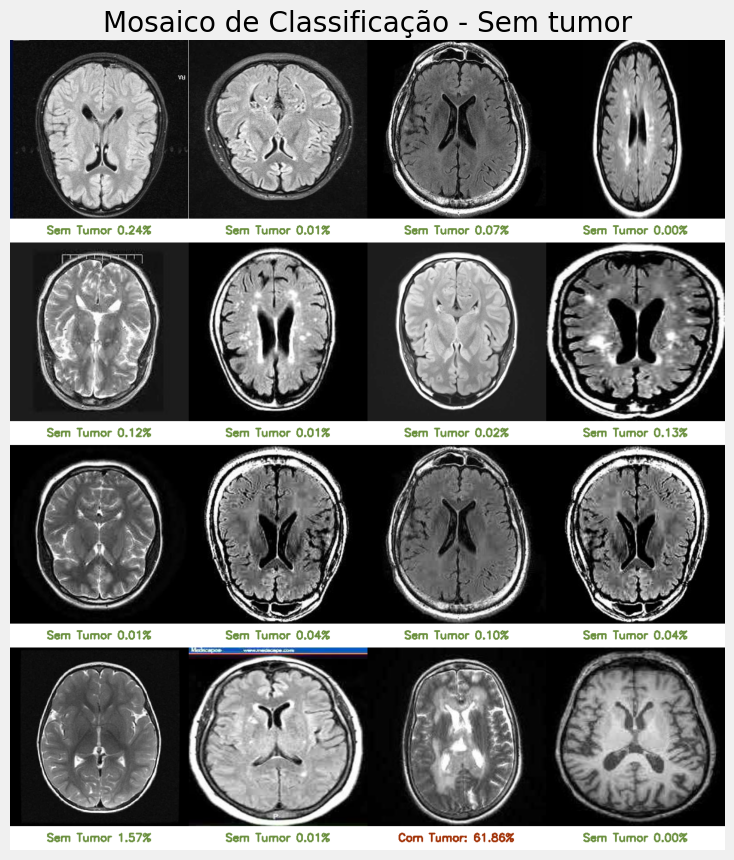

\Classificando imagem: /content/driv/MyDrive/deteccao_tumores/dataset_teste/com_tumor/recorte/Cópia de Te-meTr_0009.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
\Classificando imagem: /content/driv/MyDrive/deteccao_tumores/dataset_teste/com_tumor/recorte/Cópia de Te-meTr_0006.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
\Classificando imagem: /content/driv/MyDrive/deteccao_tumores/dataset_teste/com_tumor/recorte/Cópia de Te-meTr_0007.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
\Classificando imagem: /content/driv/MyDrive/deteccao_tumores/dataset_teste/com_tumor/recorte/Cópia de Te-meTr_0005.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
\Classificando imagem: /content/driv/MyDrive/deteccao_tumores/dataset_teste/com_tumor/recorte/Cópia de Te-meTr_0003.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
\Classificando imagem: /content/driv/MyDrive/deteccao_tumores/dataset_teste/com_tumor/recorte/Cópia de Te-meTr_0004.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
\Classificando imagem: /content/driv/MyDrive/d

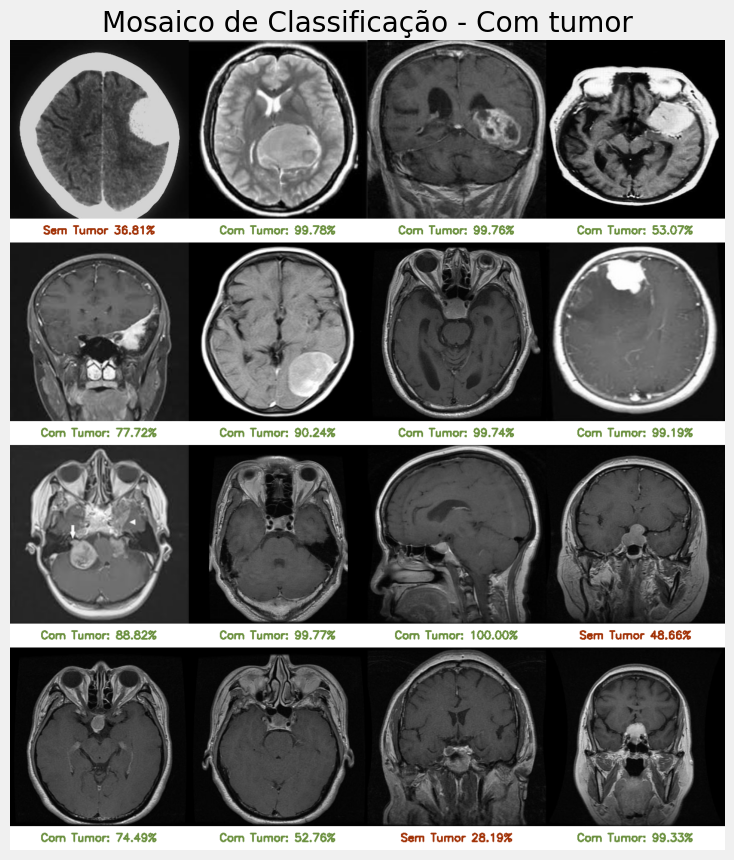

In [ ]:
def criar_mosaico(titulo, cor_sim, cor_nao, arquivos, modelo, rows, cols):
    """
    Cria um mosaico com imagens classificadas e seus respectivos resulktados.
    """
    imagens = []
    for arquivo in arquivos:
        img = cv2.imread(arquivo)
        if img is not None:
            img = cv2.resize(img, (largura, altura))
            imagens.append(img)
        else:
            print(f"Nao foi possivel carregar imagem {arquivo}")

    if not imagens:
        print("Nenhuma imagem carregada.")
        return

    # Define tamanho do mosaico
    img_h, img_w, _ = imagens[0].shape
    texto_h = 40  # Espaço para texto
    mosaico_h = (img_h + texto_h) * rows
    mosaico_w = img_w * cols
    mosaico = np.zeros((mosaico_h, mosaico_w, 3), dtype=np.uint8)
    mosaico.fill(255)


    # Classificação das imagens de RM
    imagem_index = 0
    for r in range(rows):
        for c in range(cols):
            if imagem_index < len(imagens):
                # Place the image
                mosaico[r * (img_h + texto_h):r * (img_h + texto_h) + img_h, c * img_w:(c + 1) * img_w] = imagens[imagem_index]

                # Classificação
                print(f"\Classificando imagem: {arquivos[imagem_index]}")
                # Normaliza imagem e realiza predicao
                img_to_predict = cv2.imread(arquivos[imagem_index])
                img_to_predict = cv2.resize(img_to_predict, (largura, altura))
                img_to_predict = cv2.cvtColor(img_to_predict, cv2.COLOR_BGR2RGB)
                img_to_predict = normalize(img_to_predict, axis=1)
                img_to_predict = img_to_predict.reshape(1, largura, altura, 3)
                predicao = modelo.predict(img_to_predict)
                probabilidade = predicao[0][0] * 100
                # Presença de tunmor: precisao acima de 50%
                if predicao[0][0] > 0.5:
                    texto_img_classificada = f"Com Tumor: {probabilidade:.2f}%"
                    cor = cor_sim # Cor definida para respostas certas/erradas
                    # print(f"Diagnóstico: Tumor Detectado (Probabilidade: {probabilidade:.2f}%)")
                else:
                    texto_img_classificada = f"Sem Tumor {probabilidade:.2f}%"
                    cor = cor_nao
                    # print(f"Diagnóstico: Sem Tumor (Probabilidade de ser tumor: {probabilidade:.2f}%)")

                # Adicionando texto abaixo da imagem
                fonte = cv2.FONT_HERSHEY_SIMPLEX
                fonte_scala = 0.6
                fonte_peso = 2
                text_size, _ = cv2.getTextSize(texto_img_classificada, fonte, fonte_scala, fonte_peso)
                text_x = c * img_w + (img_w - text_size[0]) // 2  # Centralização do texto
                text_y = r * (img_h + texto_h) + img_h + 25 # Posição do texto
                cv2.putText(mosaico, texto_img_classificada, (text_x, text_y), fonte, fonte_scala, cor, fonte_peso)

                imagem_index += 1

    plt.figure(figsize=(10, 10))
    # Conversão para escala RGB
    plt.imshow(cv2.cvtColor(mosaico, cv2.COLOR_BGR2RGB))
    plt.title(titulo)
    plt.axis('off')
    plt.show()

path_teste_sem_tumor = '/content/driv/MyDrive/deteccao_tumores/dataset_teste/sem_tumor/recorte'
path_teste_com_tumor = '/content/driv/MyDrive/deteccao_tumores/dataset_teste/com_tumor/recorte'
arquivos_com_tumor = []
arquivos_sem_tumor = []
valid_extensions = ['.png', '.jpg', '.jpeg'] # Extensões válidas

def listar_dir(path_pasta):
  arquivos = []
  for nome_arquivo in os.listdir(path_pasta):
      # Extensão
      ext = os.path.splitext(nome_arquivo)[1].lower()

      # Verifica se a extensao do arquivo está na lista de extensões validas
      if ext in valid_extensions:
          path_completo = os.path.join(path_pasta, nome_arquivo)
          arquivos.append(path_completo)

  return arquivos

arquivos_sem_tumor = listar_dir(path_teste_sem_tumor)
arquivos_com_tumor = listar_dir(path_teste_com_tumor)

# Cria mosaico e classifica imagens de teste
criar_mosaico('Mosaico de Classificação - Sem tumor',(8,51,162),(64, 145,108),arquivos_sem_tumor, modelo, rows=4, cols=4)
criar_mosaico('Mosaico de Classificação - Com tumor',(64, 145,108),(8,51,162),arquivos_com_tumor, modelo, rows=4, cols=4)

In [ ]:
def classificacao(titulo, com_tumor, sem_tumor, arquivos, modelo):
    """
    Cria um mosaico com imagens classificadas e seus respectivos resulktados.
    """
    imagens = []
    # Classificação das imagens de RM
    erro = 0
    for arquivo in arquivos:
        img = cv2.imread(arquivo)
        img = cv2.resize(img, (largura, altura))
        imagens.append(img)
        print(f"\Classificando imagem {titulo}: {arquivo}")
        # Normaliza imagem e realiza predicao
        img_to_predict = cv2.imread(arquivo)
        img_to_predict = cv2.resize(img_to_predict, (largura, altura))
        img_to_predict = cv2.cvtColor(img_to_predict, cv2.COLOR_BGR2RGB)
        img_to_predict = normalize(img_to_predict, axis=1)
        img_to_predict = img_to_predict.reshape(1, largura, altura, 3)
        predicao = modelo.predict(img_to_predict)
        probabilidade = predicao[0][0] * 100
        # Presença de tunmor: precisao acima de 50%
        if predicao[0][0] > 0.5:
            texto_img_classificada = f"Com Tumor: {probabilidade:.2f}%"
            if com_tumor == True:
                erro += 1
                print(arquivo)
            print(f"Diagnóstico: Tumor Detectado (Probabilidade: {probabilidade:.2f}%)")
        else:
            texto_img_classificada = f"Sem Tumor {probabilidade:.2f}%"
            print(f"Diagnóstico: Sem Tumor (Probabilidade de ser tumor: {probabilidade:.2f}%)")
            if sem_tumor == True:
                erro += 1
                print(arquivo)
    return erro

path_teste_sem_tumor_todos = '/content/driv/MyDrive/deteccao_tumores/dataset_teste/sem_tumor'
path_teste_com_tumor_todos = '/content/driv/MyDrive/deteccao_tumores/dataset_teste/com_tumor'
arquivos_com_tumor_todos = []
arquivos_sem_tumor_todos = []
valid_extensions = ['.png', '.jpg', '.jpeg'] # Extensões válidas

arquivos_sem_tumor_todos = listar_dir(path_teste_sem_tumor_todos)
arquivos_com_tumor_todos = listar_dir(path_teste_com_tumor_todos)

# Cria mosaico e classifica imagens de teste
erros_sem_tumor = classificacao('sem tumor',True,False,arquivos_sem_tumor_todos, modelo) # retorna falsos positivos
erros_com_tumor = classificacao('Mosaico de Classificação - Com tumor',False,True,arquivos_com_tumor_todos, modelo)  # retorna falsos negativos

print(f"Erros sem tumor: {erros_sem_tumor}")
print(f"Erros com tumor: {erros_com_tumor}")

fp = erros_sem_tumor
fn = erros_com_tumor
tp = 300 - erros_sem_tumor
tn = 300 - erros_com_tumor

\Classificando imagem sem tumor: /content/driv/MyDrive/deteccao_tumores/dataset_teste/sem_tumor/Tr-no_0029.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
Diagnóstico: Sem Tumor (Probabilidade de ser tumor: 0.00%)
\Classificando imagem sem tumor: /content/driv/MyDrive/deteccao_tumores/dataset_teste/sem_tumor/Tr-no_0051.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
Diagnóstico: Sem Tumor (Probabilidade de ser tumor: 0.02%)
\Classificando imagem sem tumor: /content/driv/MyDrive/deteccao_tumores/dataset_teste/sem_tumor/Tr-no_0011.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
Diagnóstico: Sem Tumor (Probabilidade de ser tumor: 0.00%)
\Classificando imagem sem tumor: /content/driv/MyDrive/deteccao_tumores/dataset_teste/sem_tumor/Tr-noTr_0004.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
/content/driv/MyDrive/deteccao_tumores/dataset_teste/sem_tumor/Tr-noTr_0004.jpg
Diagnóstico: Tumor Detectado (Probabilidade: 56.26%)
\Classificando imagem sem tumor: /content/driv/MyDrive/deteccao_tumores/dataset_teste/sem_tu